In [1]:
IRT_DIMS = 0
DATASET = 'matrix'    
ITEM_FEATURES = 'False'
ITEM_FEATURES = False if ITEM_FEATURES == 'False' else True

In [2]:
import sys, os, shutil
import pickle
import time
import numpy as np
from utils import (mymode, load_data_heterogeneous, create_data_object_heterogeneous)
import seaborn as sns

from IRT import MIRT_2PL
from Heterogeneous_embedder import EmbedderHeterogeneous, train_embedder_heterogeneous, test_embedder_heterogeneous
from manage_experiments import perform_cross_validation

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [3]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Initialise
parameters = {
    'df_name': None,
    'epochs': 10000,
    'learning_rate': 0.005,
    'weight_decay': 0,
    'early_stopping': 200,
    'n_splits': 10,
    'device': 'cuda:0',
    'batch_size': 2**14,
    'neighbours': [50, 50]
    }

if IRT_DIMS > 0:
    parameters['model_type'] = 'IRT'
    parameters['hidden_dims'] = IRT_DIMS
    parameters['lambda1'] = 0
    parameters['lambda2'] = 0
    OUTNAME = 'IRT'
else:
    parameters['model_type'] = 'GNN'
    parameters['hidden_dims'] = [16,8]
    OUTNAME = 'SAGE' 

if ITEM_FEATURES:
    OUTNAME = OUTNAME + '_scales'
    
print(parameters)
print(DATASET)

{'df_name': None, 'epochs': 10000, 'learning_rate': 0.005, 'weight_decay': 0, 'early_stopping': 200, 'n_splits': 10, 'device': 'cuda:0', 'batch_size': 16384, 'neighbours': [50, 50], 'model_type': 'GNN', 'hidden_dims': [16, 8]}
matrix


In [5]:
DATA_FILE = 'data/mindsteps_set_' + DATASET
df = load_data_heterogeneous(DATA_FILE)
data, df_student, df_item, df_edge = create_data_object_heterogeneous(df, return_aux_data=True, item_features=ITEM_FEATURES)

(5613692, 24)


In [6]:
df.columns

Index(['studentId', 'code', 'motherTongue', 'Gender', 'scale', 'matrix',
       'IRT_difficulty', 'topic', 'responseformat', 'textlength', 'score',
       'age', 'grade', 'viewingTime', 'timestamp', 'useCase', 'assessmentId',
       'ability', 'frequency', 'previous_sessions', 'years_from_start',
       'matdiff', 'matcode', 'domain'],
      dtype='object')

In [7]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,timestamp,useCase,assessmentId,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,1.0,0.0,fhoe,F.1.A.1.c.1,-0.370330,Monologe und Dialoge,NaN,NaN,...,7.830814e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
1,0,1,1.0,0.0,fles,F.2.A.1.b.3,-0.494880,Berichte,NaN,NaN,...,7.833807e-312,ms-thema-auto,0D59C4843FFC39195EDE1DD140506CF3DF8BC6F132AAF5...,0.657010,2.727266,3,1.10,,,f
2,0,2,1.0,0.0,mzuv,MA.1.A.3.f,0.368830,Gemischte Grundoperationen,single choice,NaN,...,7.661659e-312,ms-kber,2B0D3CD783DB6BE2341F8CF101395AC464874A993E8CCF...,0.751265,1000000.000000,0,0.00,,,m
3,0,3,1.0,0.0,fhoe,F.1.A.1.d.1,0.367442,Aus TV und Radio,NaN,NaN,...,7.830815e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
4,0,4,1.0,0.0,fles,F.2.A.1.d.1,1.160150,Berichte,NaN,212.0,...,7.833807e-312,ms-thema-auto,0D59C4843FFC39195EDE1DD140506CF3DF8BC6F132AAF5...,0.657010,2.727266,3,1.10,,,f


edge_dim = data['student', 'responds', 'item'].edge_attr.shape[1]
if IRT_DIMS > 0:
    model = MIRT_2PL(IRT_DIMS, edge_dim, data)
else:
    model = EmbedderHeterogeneous( 
        n_students =  data['student'].x.size(0),
        n_items = data['item'].x.size(0),
        student_inchannel = data['student'].x.size(1),
        item_inchannel = data['item'].x.size(1),
        hidden_channels=parameters['hidden_dims'],
        edge_channel=edge_dim,
        metadata=data.metadata()
        ).to(device)
    
model = model.to(device)

In [8]:
output_dict, model = perform_cross_validation(data, parameters, save_embeddings=True, save_subgraph=True, final_fit=True)

0it [00:00, ?it/s]

Parameters
{'n_students': 51508, 'n_items': 17868, 'student_inchannel': 2, 'item_inchannel': None, 'hidden_channels': [16, 8], 'edge_channel': 2}



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.84s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.77s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.89s/it]

100%|██████████| 4/4 [00:10<00:00,  2.54s/it]



Epoch: 001, Loss: 0.6180, Val: 0.5001, Test: 0.5001



  0%|          | 1/10000 [00:11<31:39:27, 11.40s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.68s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.74s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.76s/it]

100%|██████████| 4/4 [00:09<00:00,  2.47s/it]



Epoch: 002, Loss: 0.5452, Val: 0.5023, Test: 0.5021



  0%|          | 2/10000 [00:22<30:58:16, 11.15s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.85s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.82s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.76s/it]

100%|██████████| 4/4 [00:10<00:00,  2.58s/it]



Epoch: 003, Loss: 0.5133, Val: 0.5260, Test: 0.5259



  0%|          | 3/10000 [00:33<31:12:29, 11.24s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.52s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.11s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.09s/it]

100%|██████████| 4/4 [00:10<00:00,  2.72s/it]

  0%|          | 4/10000 [00:45<31:31:01, 11.35s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  3.00s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.96s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.83s/it]

100%|██████████| 4/4 [00:10<00:00,  2.58s/it]

  0%|          | 5/10000 [00:56<31:09:07, 11.22s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.80s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.76s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.13s/it]

100%|██████████| 4/4 [00:11<00:00,  2.77s/it]

  0%|          | 6/10000 [01:07<31:33:32, 11.37s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.69s/it]

 50%|█████     |


Epoch: 007, Loss: 0.5016, Val: 0.5406, Test: 0.5399



  0%|          | 7/10000 [01:18<30:53:04, 11.13s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.78s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.92s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.86s/it]

100%|██████████| 4/4 [00:10<00:00,  2.55s/it]



Epoch: 008, Loss: 0.4953, Val: 0.5604, Test: 0.5586



  0%|          | 8/10000 [01:29<31:00:43, 11.17s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.83s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.87s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.18s/it]

100%|██████████| 4/4 [00:11<00:00,  2.85s/it]



Epoch: 009, Loss: 0.4915, Val: 0.5752, Test: 0.5736



  0%|          | 9/10000 [01:42<32:12:02, 11.60s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.68s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.65s/it]

 75%|███████▌  | 3/4 [00:08<00:03,  3.10s/it]

100%|██████████| 4/4 [00:10<00:00,  2.65s/it]



Epoch: 010, Loss: 0.4886, Val: 0.5838, Test: 0.5843



  0%|          | 10/10000 [01:53<32:14:12, 11.62s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.70s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.77s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.67s/it]

100%|██████████| 4/4 [00:09<00:00,  2.36s/it]



Epoch: 011, Loss: 0.4844, Val: 0.5909, Test: 0.5921



  0%|          | 11/10000 [02:04<31:15:01, 11.26s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.71s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.86s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.77s/it]

100%|██████████| 4/4 [00:09<00:00,  2.46s/it]



Epoch: 012, Loss: 0.4788, Val: 0.5985, Test: 0.5999



  0%|          | 12/10000 [02:15<30:54:29, 11.14s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.73s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.81s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.74s/it]

100%|██████████| 4/4 [00:09<00:00,  2.46s/it]



Epoch: 013, Loss: 0.4738, Val: 0.6054, Test: 0.6073



  0%|          | 13/10000 [02:26<30:35:49, 11.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.65s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.64s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.63s/it]

100%|██████████| 4/4 [00:09<00:00,  2.33s/it]



Epoch: 014, Loss: 0.4688, Val: 0.6125, Test: 0.6141



  0%|          | 14/10000 [02:36<29:56:51, 10.80s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.54s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.57s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.81s/it]

100%|██████████| 4/4 [00:09<00:00,  2.45s/it]



Epoch: 015, Loss: 0.4641, Val: 0.6192, Test: 0.6203



  0%|          | 15/10000 [02:47<30:02:08, 10.83s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.45s/it]

 50%|█████     | 2/4 [00:06<00:05,  2.95s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.81s/it]

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]



Epoch: 016, Loss: 0.4594, Val: 0.6249, Test: 0.6265



  0%|          | 16/10000 [02:58<30:27:04, 10.98s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.59s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.62s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.58s/it]

100%|██████████| 4/4 [00:09<00:00,  2.34s/it]



Epoch: 017, Loss: 0.4566, Val: 0.6308, Test: 0.6322



  0%|          | 17/10000 [03:08<29:57:07, 10.80s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.66s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.70s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.88s/it]

100%|██████████| 4/4 [00:10<00:00,  2.52s/it]



Epoch: 018, Loss: 0.4525, Val: 0.6355, Test: 0.6373



  0%|          | 18/10000 [03:20<30:14:23, 10.91s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.68s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.76s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.64s/it]

100%|██████████| 4/4 [00:09<00:00,  2.37s/it]



Epoch: 019, Loss: 0.4486, Val: 0.6397, Test: 0.6422



  0%|          | 19/10000 [03:30<29:54:21, 10.79s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.81s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.82s/it]

100%|██████████| 4/4 [00:10<00:00,  2.51s/it]



Epoch: 020, Loss: 0.4457, Val: 0.6437, Test: 0.6467



  0%|          | 20/10000 [03:41<30:10:56, 10.89s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.84s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.76s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.72s/it]

100%|██████████| 4/4 [00:09<00:00,  2.46s/it]



Epoch: 021, Loss: 0.4428, Val: 0.6469, Test: 0.6505



  0%|          | 21/10000 [03:52<30:08:07, 10.87s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.76s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.81s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.11s/it]

100%|██████████| 4/4 [00:10<00:00,  2.67s/it]



Epoch: 022, Loss: 0.4393, Val: 0.6502, Test: 0.6531



  0%|          | 22/10000 [04:04<30:58:30, 11.18s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.71s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.98s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.04s/it]

100%|██████████| 4/4 [00:11<00:00,  2.82s/it]



Epoch: 023, Loss: 0.4372, Val: 0.6528, Test: 0.6550



  0%|          | 23/10000 [04:17<32:08:07, 11.60s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.15s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.85s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.81s/it]

100%|██████████| 4/4 [00:10<00:00,  2.55s/it]



Epoch: 024, Loss: 0.4333, Val: 0.6552, Test: 0.6568



  0%|          | 24/10000 [04:28<31:53:54, 11.51s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.71s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.95s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.87s/it]

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]



Epoch: 025, Loss: 0.4312, Val: 0.6566, Test: 0.6586



  0%|          | 25/10000 [04:39<31:59:58, 11.55s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.05s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.02s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.96s/it]

100%|██████████| 4/4 [00:10<00:00,  2.68s/it]



Epoch: 026, Loss: 0.4287, Val: 0.6584, Test: 0.6599



  0%|          | 26/10000 [04:52<32:23:59, 11.69s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.95s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.82s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.79s/it]

100%|██████████| 4/4 [00:09<00:00,  2.48s/it]



Epoch: 027, Loss: 0.4264, Val: 0.6605, Test: 0.6619



  0%|          | 27/10000 [05:03<31:52:29, 11.51s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.60s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.24s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.07s/it]

100%|██████████| 4/4 [00:10<00:00,  2.73s/it]



Epoch: 028, Loss: 0.4237, Val: 0.6629, Test: 0.6645



  0%|          | 28/10000 [05:15<32:12:54, 11.63s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.98s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.84s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.71s/it]

100%|██████████| 4/4 [00:09<00:00,  2.43s/it]



Epoch: 029, Loss: 0.4221, Val: 0.6656, Test: 0.6677



  0%|          | 29/10000 [05:25<31:27:38, 11.36s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.72s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.78s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.79s/it]

100%|██████████| 4/4 [00:09<00:00,  2.45s/it]



Epoch: 030, Loss: 0.4197, Val: 0.6686, Test: 0.6707



  0%|          | 30/10000 [05:36<31:01:00, 11.20s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.66s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.25s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.95s/it]

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]



Epoch: 031, Loss: 0.4176, Val: 0.6722, Test: 0.6739



  0%|          | 31/10000 [05:48<31:26:29, 11.35s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.63s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.75s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.73s/it]

100%|██████████| 4/4 [00:10<00:00,  2.51s/it]



Epoch: 032, Loss: 0.4153, Val: 0.6752, Test: 0.6775



  0%|          | 32/10000 [05:59<31:12:24, 11.27s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.72s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.86s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.27s/it]

100%|██████████| 4/4 [00:11<00:00,  2.77s/it]



Epoch: 033, Loss: 0.4139, Val: 0.6782, Test: 0.6805



  0%|          | 33/10000 [06:11<31:57:21, 11.54s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.85s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.90s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.79s/it]

100%|██████████| 4/4 [00:10<00:00,  2.52s/it]



Epoch: 034, Loss: 0.4115, Val: 0.6808, Test: 0.6826



  0%|          | 34/10000 [06:22<31:42:07, 11.45s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.01s/it]

 50%|█████     | 2/4 [00:06<00:05,  3.00s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.73s/it]

100%|██████████| 4/4 [00:09<00:00,  2.48s/it]



Epoch: 035, Loss: 0.4095, Val: 0.6836, Test: 0.6854



  0%|          | 35/10000 [06:33<31:14:54, 11.29s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.69s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.69s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.87s/it]

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]



Epoch: 036, Loss: 0.4073, Val: 0.6870, Test: 0.6886



  0%|          | 36/10000 [06:44<31:04:01, 11.22s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.78s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.72s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.70s/it]

100%|██████████| 4/4 [00:09<00:00,  2.40s/it]



Epoch: 037, Loss: 0.4056, Val: 0.6894, Test: 0.6908



  0%|          | 37/10000 [06:55<30:32:14, 11.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.73s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.19s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.95s/it]

100%|██████████| 4/4 [00:10<00:00,  2.58s/it]



Epoch: 038, Loss: 0.4039, Val: 0.6917, Test: 0.6929



  0%|          | 38/10000 [07:06<30:45:20, 11.11s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.62s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.71s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.68s/it]

100%|██████████| 4/4 [00:09<00:00,  2.39s/it]



Epoch: 039, Loss: 0.4026, Val: 0.6938, Test: 0.6951



  0%|          | 39/10000 [07:17<30:17:13, 10.95s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.61s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.67s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.68s/it]

100%|██████████| 4/4 [00:09<00:00,  2.40s/it]



Epoch: 040, Loss: 0.4021, Val: 0.6961, Test: 0.6971



  0%|          | 40/10000 [07:28<30:24:20, 10.99s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.97s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.98s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.97s/it]

100%|██████████| 4/4 [00:10<00:00,  2.61s/it]



Epoch: 041, Loss: 0.4004, Val: 0.6979, Test: 0.6987



  0%|          | 41/10000 [07:39<30:49:49, 11.14s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.51s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.65s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.82s/it]

100%|██████████| 4/4 [00:10<00:00,  2.53s/it]



Epoch: 042, Loss: 0.3982, Val: 0.6994, Test: 0.7002



  0%|          | 42/10000 [07:51<31:10:03, 11.27s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.94s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.68s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.63s/it]

100%|██████████| 4/4 [00:09<00:00,  2.36s/it]



Epoch: 043, Loss: 0.3975, Val: 0.7010, Test: 0.7021



  0%|          | 43/10000 [08:01<30:32:40, 11.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.24s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.03s/it]

100%|██████████| 4/4 [00:11<00:00,  2.76s/it]



Epoch: 044, Loss: 0.3969, Val: 0.7018, Test: 0.7031



  0%|          | 44/10000 [08:14<31:29:39, 11.39s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.14s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.96s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.00s/it]

100%|██████████| 4/4 [00:10<00:00,  2.72s/it]



Epoch: 045, Loss: 0.3958, Val: 0.7030, Test: 0.7044



  0%|          | 45/10000 [08:26<32:15:54, 11.67s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.14s/it]

 50%|█████     | 2/4 [00:06<00:07,  3.53s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.13s/it]

100%|██████████| 4/4 [00:11<00:00,  2.94s/it]



Epoch: 046, Loss: 0.3937, Val: 0.7042, Test: 0.7056



  0%|          | 46/10000 [08:39<33:20:58, 12.06s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.75s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.80s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.78s/it]

100%|██████████| 4/4 [00:09<00:00,  2.50s/it]



Epoch: 047, Loss: 0.3935, Val: 0.7049, Test: 0.7067



  0%|          | 47/10000 [08:50<32:28:02, 11.74s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.95s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.80s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.69s/it]

100%|██████████| 4/4 [00:09<00:00,  2.47s/it]



Epoch: 048, Loss: 0.3916, Val: 0.7058, Test: 0.7072



  0%|          | 48/10000 [09:01<31:45:53, 11.49s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.67s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.69s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.80s/it]

100%|██████████| 4/4 [00:10<00:00,  2.53s/it]



Epoch: 049, Loss: 0.3920, Val: 0.7066, Test: 0.7081



  0%|          | 49/10000 [09:12<31:30:19, 11.40s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.85s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.99s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.77s/it]

100%|██████████| 4/4 [00:10<00:00,  2.52s/it]



Epoch: 050, Loss: 0.3912, Val: 0.7070, Test: 0.7087



  0%|          | 50/10000 [09:23<31:25:22, 11.37s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.72s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.65s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.64s/it]

100%|██████████| 4/4 [00:09<00:00,  2.41s/it]



Epoch: 051, Loss: 0.3910, Val: 0.7079, Test: 0.7089



  1%|          | 51/10000 [09:34<30:52:13, 11.17s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.83s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.91s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.04s/it]

100%|██████████| 4/4 [00:10<00:00,  2.73s/it]



Epoch: 052, Loss: 0.3903, Val: 0.7085, Test: 0.7093



  1%|          | 52/10000 [09:46<31:42:53, 11.48s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.78s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.72s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.24s/it]

100%|██████████| 4/4 [00:10<00:00,  2.73s/it]



Epoch: 053, Loss: 0.3910, Val: 0.7090, Test: 0.7102



  1%|          | 53/10000 [09:58<32:15:46, 11.68s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.08s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.93s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.92s/it]

100%|██████████| 4/4 [00:10<00:00,  2.62s/it]



Epoch: 054, Loss: 0.3893, Val: 0.7096, Test: 0.7106



  1%|          | 54/10000 [10:10<32:14:01, 11.67s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.77s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.64s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.60s/it]

100%|██████████| 4/4 [00:09<00:00,  2.33s/it]



Epoch: 055, Loss: 0.3894, Val: 0.7099, Test: 0.7107



  1%|          | 55/10000 [10:20<31:00:25, 11.22s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.73s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.68s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.68s/it]

100%|██████████| 4/4 [00:09<00:00,  2.44s/it]



Epoch: 056, Loss: 0.3892, Val: 0.7103, Test: 0.7113



  1%|          | 56/10000 [10:31<30:45:08, 11.13s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.16s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.96s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.96s/it]

100%|██████████| 4/4 [00:10<00:00,  2.66s/it]



Epoch: 057, Loss: 0.3883, Val: 0.7107, Test: 0.7116



  1%|          | 57/10000 [10:43<31:28:31, 11.40s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.85s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.44s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.18s/it]

100%|██████████| 4/4 [00:11<00:00,  2.76s/it]



Epoch: 058, Loss: 0.3887, Val: 0.7109, Test: 0.7117



  1%|          | 58/10000 [10:55<32:07:40, 11.63s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.68s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.75s/it]

100%|██████████| 4/4 [00:09<00:00,  2.46s/it]



Epoch: 059, Loss: 0.3891, Val: 0.7109, Test: 0.7116



  1%|          | 59/10000 [11:06<31:30:48, 11.41s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

 50%|█████     | 2/4 [00:08<00:08,  4.10s/it]

 75%|███████▌  | 3/4 [00:11<00:03,  3.78s/it]

100%|██████████| 4/4 [00:13<00:00,  3.37s/it]



Epoch: 060, Loss: 0.3885, Val: 0.7115, Test: 0.7124



  1%|          | 60/10000 [11:22<34:49:16, 12.61s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:05<00:15,  5.12s/it]

 50%|█████     | 2/4 [00:09<00:09,  4.97s/it]

 75%|███████▌  | 3/4 [00:13<00:04,  4.48s/it]

100%|██████████| 4/4 [00:16<00:00,  4.08s/it]



Epoch: 061, Loss: 0.3882, Val: 0.7119, Test: 0.7127



  1%|          | 61/10000 [11:40<39:29:14, 14.30s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:04<00:14,  4.87s/it]

 50%|█████     | 2/4 [00:09<00:09,  4.96s/it]

 75%|███████▌  | 3/4 [00:14<00:05,  5.00s/it]

100%|██████████| 4/4 [00:17<00:00,  4.39s/it]



Epoch: 062, Loss: 0.3885, Val: 0.7122, Test: 0.7129



  1%|          | 62/10000 [11:59<43:17:10, 15.68s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.93s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.87s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.90s/it]

100%|██████████| 4/4 [00:10<00:00,  2.66s/it]



Epoch: 063, Loss: 0.3884, Val: 0.7123, Test: 0.7129



  1%|          | 63/10000 [12:11<40:08:53, 14.54s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.93s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.96s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.96s/it]

100%|██████████| 4/4 [00:11<00:00,  2.97s/it]



Epoch: 064, Loss: 0.3881, Val: 0.7125, Test: 0.7131



  1%|          | 64/10000 [12:24<39:16:24, 14.23s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:04<00:13,  4.49s/it]

 50%|█████     | 2/4 [00:08<00:08,  4.47s/it]

 75%|███████▌  | 3/4 [00:11<00:03,  3.82s/it]

100%|██████████| 4/4 [00:13<00:00,  3.46s/it]



Epoch: 065, Loss: 0.3881, Val: 0.7128, Test: 0.7132



  1%|          | 65/10000 [12:40<40:16:35, 14.59s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.61s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.14s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.48s/it]

100%|██████████| 4/4 [00:12<00:00,  3.07s/it]



Epoch: 066, Loss: 0.3877, Val: 0.7130, Test: 0.7135



  1%|          | 66/10000 [12:54<39:55:47, 14.47s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.48s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.11s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.29s/it]

100%|██████████| 4/4 [00:12<00:00,  3.09s/it]



Epoch: 067, Loss: 0.3881, Val: 0.7131, Test: 0.7135



  1%|          | 67/10000 [13:08<39:41:33, 14.39s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.03s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.88s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.87s/it]

100%|██████████| 4/4 [00:10<00:00,  2.67s/it]

  1%|          | 68/10000 [13:20<37:27:21, 13.58s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.40s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.14s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.10s/it]

100%|██████████| 4/4 [00:11<00:00,  2.76s/it]



Epoch: 069, Loss: 0.3875, Val: 0.7132, Test: 0.7138



  1%|          | 69/10000 [13:32<36:22:16, 13.18s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.73s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.31s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.32s/it]

100%|██████████| 4/4 [00:11<00:00,  2.96s/it]



Epoch: 070, Loss: 0.3881, Val: 0.7133, Test: 0.7139



  1%|          | 70/10000 [13:45<36:13:53, 13.14s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.56s/it]

 50%|█████     | 2/4 [00:07<00:07,  3.64s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.45s/it]

100%|██████████| 4/4 [00:12<00:00,  3.05s/it]

  1%|          | 71/10000 [13:58<35:57:27, 13.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.26s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.34s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.15s/it]

100%|██████████| 4/4 [00:11<00:00,  2.84s/it]



Epoch: 072, Loss: 0.3880, Val: 0.7136, Test: 0.7141



  1%|          | 72/10000 [14:10<35:35:17, 12.90s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.68s/it]

 50%|█████     | 2/4 [00:07<00:07,  3.90s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.51s/it]

100%|██████████| 4/4 [00:12<00:00,  3.14s/it]

  1%|          | 73/10000 [14:23<35:44:17, 12.96s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.70s/it]

 50%|█████     | 2/4 [00:07<00:06,  3.48s/it]

 75%|███████▌  | 3/4 [00:11<00:03,  3.80s/it]

100%|██████████| 4/4 [00:13<00:00,  3.26s/it]



Epoch: 074, Loss: 0.3872, Val: 0.7137, Test: 0.7145



  1%|          | 74/10000 [14:38<36:42:34, 13.31s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.23s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.19s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.44s/it]

100%|██████████| 4/4 [00:12<00:00,  3.02s/it]



Epoch: 075, Loss: 0.3876, Val: 0.7138, Test: 0.7145



  1%|          | 75/10000 [14:51<37:03:18, 13.44s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.39s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.16s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.43s/it]

100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

  1%|          | 76/10000 [15:04<36:17:10, 13.16s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.90s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.06s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.95s/it]

100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

  1%|          | 77/10000 [15:16<35:48:42, 12.99s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.13s/it]

 50%|█████     | 2/4 [00:06<00:07,  3.51s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.27s/it]

100%|██████████| 4/4 [00:12<00:00,  3.24s/it]



Epoch: 078, Loss: 0.3875, Val: 0.7140, Test: 0.7150



  1%|          | 78/10000 [15:32<37:49:41, 13.73s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.89s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.27s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.04s/it]

100%|██████████| 4/4 [00:11<00:00,  2.83s/it]

  1%|          | 79/10000 [15:44<36:22:20, 13.20s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.89s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.32s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.08s/it]

100%|██████████| 4/4 [00:11<00:00,  2.86s/it]

  1%|          | 80/10000 [15:56<35:22:54, 12.84s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.81s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.36s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.02s/it]

100%|██████████| 4/4 [00:11<00:00,  2.79s/it]



Epoch: 081, Loss: 0.3862, Val: 0.7143, Test: 0.7147



  1%|          | 81/10000 [16:08<35:05:02, 12.73s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.59s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.34s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.16s/it]

100%|██████████| 4/4 [00:11<00:00,  2.85s/it]



Epoch: 082, Loss: 0.3869, Val: 0.7143, Test: 0.7148



  1%|          | 82/10000 [16:21<35:03:20, 12.72s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.46s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.37s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.11s/it]

100%|██████████| 4/4 [00:11<00:00,  2.83s/it]

  1%|          | 83/10000 [16:33<34:29:55, 12.52s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.03s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.82s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.80s/it]

100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

  1%|          | 84/10000 [16:45<33:51:42, 12.29s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.80s/it]

 50%|█████     | 2/4 [00:07<00:07,  3.91s/it]

 75%|███████▌  | 3/4 [00:11<00:03,  3.94s/it]

100%|██████████| 4/4 [00:13<00:00,  3.39s/it]



Epoch: 085, Loss: 0.3863, Val: 0.7146, Test: 0.7152



  1%|          | 85/10000 [17:00<35:55:16, 13.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.69s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.68s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.62s/it]

100%|██████████| 4/4 [00:09<00:00,  2.39s/it]



Epoch: 086, Loss: 0.3869, Val: 0.7148, Test: 0.7154



  1%|          | 86/10000 [17:10<34:00:06, 12.35s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.57s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.82s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.81s/it]

100%|██████████| 4/4 [00:10<00:00,  2.54s/it]

  1%|          | 87/10000 [17:21<32:40:30, 11.87s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.24s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.93s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.80s/it]

100%|██████████| 4/4 [00:10<00:00,  2.61s/it]

  1%|          | 88/10000 [17:32<32:05:24, 11.65s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.74s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.98s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.93s/it]

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

  1%|          | 89/10000 [17:43<31:19:47, 11.38s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.98s/it]

 50%|█████  


Epoch: 090, Loss: 0.3866, Val: 0.7148, Test: 0.7157



  1%|          | 90/10000 [17:54<31:15:32, 11.36s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.94s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.78s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.70s/it]

100%|██████████| 4/4 [00:09<00:00,  2.45s/it]



Epoch: 091, Loss: 0.3863, Val: 0.7149, Test: 0.7157



  1%|          | 91/10000 [18:05<31:03:46, 11.29s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.97s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.83s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.93s/it]

100%|██████████| 4/4 [00:10<00:00,  2.64s/it]

  1%|          | 92/10000 [18:17<31:03:42, 11.29s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.88s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.96s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.04s/it]

100%|██████████| 4/4 [00:10<00:00,  2.70s/it]

  1%|          | 93/10000 [18:28<31:05:39, 11.30s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.70s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.69s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.68s/it]

100%|██████████| 4/4 [00:09<00:00,  2.48s/it]



Epoch: 094, Loss: 0.3870, Val: 0.7153, Test: 0.7157



  1%|          | 94/10000 [18:39<30:46:54, 11.19s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.93s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.85s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.88s/it]

100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

  1%|          | 95/10000 [18:50<30:31:58, 11.10s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.88s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.89s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.86s/it]

100%|██████████| 4/4 [00:10<00:00,  2.57s/it]

  1%|          | 96/10000 [19:01<30:21:22, 11.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.59s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.66s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.73s/it]

100%|██████████| 4/4 [00:09<00:00,  2.44s/it]



Epoch: 097, Loss: 0.3870, Val: 0.7153, Test: 0.7160



  1%|          | 97/10000 [19:12<30:12:01, 10.98s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.84s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.90s/it]

100%|██████████| 4/4 [00:10<00:00,  2.60s/it]



Epoch: 098, Loss: 0.3864, Val: 0.7153, Test: 0.7160



  1%|          | 98/10000 [19:23<30:32:09, 11.10s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.75s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.79s/it]

100%|██████████| 4/4 [00:10<00:00,  2.51s/it]

  1%|          | 99/10000 [19:33<30:01:48, 10.92s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.78s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.73s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.73s/it]

100%|██████████| 4/4 [00:09<00:00,  2.46s/it]



Epoch: 100, Loss: 0.3870, Val: 0.7157, Test: 0.7161



  1%|          | 100/10000 [19:44<29:59:33, 10.91s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.69s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.09s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.96s/it]

100%|██████████| 4/4 [00:10<00:00,  2.57s/it]

  1%|          | 101/10000 [19:55<29:51:31, 10.86s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.77s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.90s/it]

100%|██████████| 4/4 [00:10<00:00,  2.53s/it]



Epoch: 102, Loss: 0.3869, Val: 0.7161, Test: 0.7162



  1%|          | 102/10000 [20:06<30:07:23, 10.96s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.76s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.73s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.61s/it]

100%|██████████| 4/4 [00:09<00:00,  2.38s/it]

  1%|          | 103/10000 [20:16<29:21:37, 10.68s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.69s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.58s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.50s/it]

100%|██████████| 4/4 [00:09<00:00,  2.32s/it]

  1%|          | 104/10000 [20:26<28:42:16, 10.44s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.90s/it]

 50%|█████     | 2/4 [00:05<00:05,  3.00s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.95s/it]

100%|██████████| 4/4 [00:10<00:00,  2.68s/it]

  1%|          | 105/10000 [20:37<29:25:24, 10.70s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]

 50%|███

100%|██████████| 4/4 [00:10<00:00,  2.75s/it]

  1%|▏         | 128/10000 [24:46<30:34:14, 11.15s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.90s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.81s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.92s/it]

100%|██████████| 4/4 [00:10<00:00,  2.64s/it]

  1%|▏         | 129/10000 [24:57<30:33:33, 11.15s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.73s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.67s/it]

100%|██████████| 4/4 [00:09<00:00,  2.48s/it]

  1%|▏         | 130/10000 [25:08<29:58:54, 10.94s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.72s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.78s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.74s/it]

100%|██████████| 4/4 [00:09<00:00,  2.50s/it]

  1%|▏         | 131/10000 [25:18<29:34:17, 10.79s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌ 


Epoch: 140, Loss: 0.3868, Val: 0.7161, Test: 0.7161



  1%|▏         | 140/10000 [26:59<30:59:41, 11.32s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.13s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.89s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.89s/it]

100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

  1%|▏         | 141/10000 [27:10<30:48:04, 11.25s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.29s/it]

 50%|█████     | 2/4 [00:06<00:05,  2.98s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.86s/it]

100%|██████████| 4/4 [00:10<00:00,  2.61s/it]

  1%|▏         | 142/10000 [27:21<30:36:57, 11.18s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.93s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.86s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.86s/it]

100%|██████████| 4/4 [00:10<00:00,  2.54s/it]

  1%|▏         | 143/10000 [27:31<30:11:48, 11.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.02s/it]

 50%|███


Epoch: 162, Loss: 0.3859, Val: 0.7162, Test: 0.7162



  2%|▏         | 162/10000 [31:00<31:01:07, 11.35s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.70s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.58s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.59s/it]

100%|██████████| 4/4 [00:09<00:00,  2.31s/it]

  2%|▏         | 163/10000 [31:10<29:42:52, 10.87s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.68s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.80s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.79s/it]

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

  2%|▏         | 164/10000 [31:20<29:17:50, 10.72s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.74s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.61s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.13s/it]

100%|██████████| 4/4 [00:10<00:00,  2.73s/it]



Epoch: 165, Loss: 0.3870, Val: 0.7163, Test: 0.7164



  2%|▏         | 165/10000 [31:32<30:22:05, 11.12s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.59s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.72s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.75s/it]

100%|██████████| 4/4 [00:10<00:00,  2.53s/it]

  2%|▏         | 166/10000 [31:43<29:58:24, 10.97s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.61s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.78s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.74s/it]

100%|██████████| 4/4 [00:09<00:00,  2.44s/it]

  2%|▏         | 167/10000 [31:53<29:22:22, 10.75s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.34s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.27s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.02s/it]

100%|██████████| 4/4 [00:11<00:00,  2.77s/it]

  2%|▏         | 168/10000 [32:05<30:08:16, 11.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.59s/it]

 50%|███


Epoch: 171, Loss: 0.3860, Val: 0.7164, Test: 0.7159



  2%|▏         | 171/10000 [32:39<30:53:22, 11.31s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.32s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.92s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.90s/it]

100%|██████████| 4/4 [00:10<00:00,  2.69s/it]



Epoch: 172, Loss: 0.3865, Val: 0.7164, Test: 0.7161



  2%|▏         | 172/10000 [32:51<31:34:40, 11.57s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.06s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.87s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.77s/it]

100%|██████████| 4/4 [00:10<00:00,  2.50s/it]



Epoch: 173, Loss: 0.3867, Val: 0.7164, Test: 0.7160



  2%|▏         | 173/10000 [33:02<31:11:47, 11.43s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.78s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.69s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.58s/it]

100%|██████████| 4/4 [00:09<00:00,  2.35s/it]



Epoch: 174, Loss: 0.3870, Val: 0.7166, Test: 0.7163



  2%|▏         | 174/10000 [33:13<30:22:56, 11.13s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.30s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.02s/it]

100%|██████████| 4/4 [00:10<00:00,  2.70s/it]

  2%|▏         | 175/10000 [33:24<30:32:53, 11.19s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.83s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.42s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.11s/it]

100%|██████████| 4/4 [00:11<00:00,  2.82s/it]

  2%|▏         | 176/10000 [33:36<31:02:02, 11.37s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.91s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.77s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.67s/it]

100%|██████████| 4/4 [00:09<00:00,  2.43s/it]

  2%|▏         | 177/10000 [33:46<30:05:00, 11.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.14s/it]

 50%|███

100%|██████████| 4/4 [00:09<00:00,  2.30s/it]

  2%|▏         | 200/10000 [37:54<27:48:19, 10.21s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.85s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.65s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.57s/it]

100%|██████████| 4/4 [00:09<00:00,  2.32s/it]

  2%|▏         | 201/10000 [38:04<27:27:21, 10.09s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.61s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.67s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.68s/it]

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

  2%|▏         | 202/10000 [38:14<27:43:41, 10.19s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.61s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.56s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.48s/it]

100%|██████████| 4/4 [00:09<00:00,  2.25s/it]

  2%|▏         | 203/10000 [38:23<27:06:44,  9.96s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌ 


Epoch: 220, Loss: 0.3854, Val: 0.7166, Test: 0.7164



  2%|▏         | 220/10000 [42:10<36:09:12, 13.31s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.45s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.20s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.12s/it]

100%|██████████| 4/4 [00:11<00:00,  2.77s/it]

  2%|▏         | 221/10000 [42:21<34:46:15, 12.80s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.92s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.05s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.40s/it]

100%|██████████| 4/4 [00:11<00:00,  2.89s/it]

  2%|▏         | 222/10000 [42:33<34:13:20, 12.60s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:04<00:12,  4.07s/it]

 50%|█████     | 2/4 [00:08<00:08,  4.19s/it]

 75%|███████▌  | 3/4 [00:11<00:03,  3.55s/it]

100%|██████████| 4/4 [00:13<00:00,  3.26s/it]

  2%|▏         | 223/10000 [42:47<35:09:47, 12.95s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.59s/it]

 50%|███


Epoch: 239, Loss: 0.3865, Val: 0.7169, Test: 0.7167



  2%|▏         | 239/10000 [46:01<30:57:55, 11.42s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.93s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.89s/it]

 75%|███████▌  | 3/4 [00:08<00:03,  3.00s/it]

100%|██████████| 4/4 [00:11<00:00,  2.80s/it]

  2%|▏         | 240/10000 [46:12<31:13:57, 11.52s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.91s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.79s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.73s/it]

100%|██████████| 4/4 [00:09<00:00,  2.45s/it]

  2%|▏         | 241/10000 [46:23<30:14:58, 11.16s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.83s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.75s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.72s/it]

100%|██████████| 4/4 [00:09<00:00,  2.45s/it]

  2%|▏         | 242/10000 [46:33<29:32:08, 10.90s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.89s/it]

 50%|███

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

  3%|▎         | 265/10000 [51:02<35:42:46, 13.21s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.14s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.09s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.90s/it]

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]

  3%|▎         | 266/10000 [51:13<34:07:13, 12.62s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.82s/it]

 50%|█████     | 2/4 [00:07<00:07,  3.81s/it]

 75%|███████▌  | 3/4 [00:12<00:04,  4.27s/it]

100%|██████████| 4/4 [00:15<00:00,  3.81s/it]

  3%|▎         | 267/10000 [51:29<36:44:34, 13.59s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.05s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.13s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.02s/it]

100%|██████████| 4/4 [00:11<00:00,  2.97s/it]

  3%|▎         | 268/10000 [51:42<36:04:45, 13.35s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌ 

 75%|███████▌  | 3/4 [00:08<00:02,  2.99s/it]

100%|██████████| 4/4 [00:10<00:00,  2.62s/it]

  3%|▎         | 291/10000 [56:30<33:19:10, 12.35s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.66s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.62s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.66s/it]

100%|██████████| 4/4 [00:09<00:00,  2.39s/it]

  3%|▎         | 292/10000 [56:40<31:30:40, 11.69s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.01s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.01s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.06s/it]

100%|██████████| 4/4 [00:10<00:00,  2.72s/it]

  3%|▎         | 293/10000 [56:51<31:22:55, 11.64s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.08s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.04s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.85s/it]

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

  3%|▎         | 294/10000 [57:02<30:38:49, 11.37s/it]

 


Epoch: 315, Loss: 0.3863, Val: 0.7170, Test: 0.7165



  3%|▎         | 315/10000 [1:00:57<33:35:24, 12.49s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:04<00:13,  4.37s/it]

 50%|█████     | 2/4 [00:08<00:08,  4.15s/it]

 75%|███████▌  | 3/4 [00:11<00:03,  3.77s/it]

100%|██████████| 4/4 [00:13<00:00,  3.42s/it]

  3%|▎         | 316/10000 [1:01:11<35:03:11, 13.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.49s/it]

 50%|█████     | 2/4 [00:07<00:07,  3.73s/it]

 75%|███████▌  | 3/4 [00:11<00:03,  3.94s/it]

100%|██████████| 4/4 [00:13<00:00,  3.34s/it]

  3%|▎         | 317/10000 [1:01:25<35:47:33, 13.31s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.97s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.10s/it]

100%|██████████| 4/4 [00:11<00:00,  2.79s/it]



Epoch: 318, Loss: 0.3862, Val: 0.7171, Test: 0.7166



  3%|▎         | 318/10000 [1:01:38<35:52:55, 13.34s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.10s/it]

 50%|█████     | 2/4 [00:06<00:07,  3.55s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.64s/it]

100%|██████████| 4/4 [00:12<00:00,  3.14s/it]

  3%|▎         | 319/10000 [1:01:52<35:54:51, 13.36s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.88s/it]

 50%|█████     | 2/4 [00:07<00:07,  3.87s/it]

 75%|███████▌  | 3/4 [00:11<00:03,  3.80s/it]

100%|██████████| 4/4 [00:13<00:00,  3.46s/it]

  3%|▎         | 320/10000 [1:02:06<36:55:00, 13.73s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.47s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.47s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.29s/it]

100%|██████████| 4/4 [00:12<00:00,  3.03s/it]

  3%|▎         | 321/10000 [1:02:20<36:37:21, 13.62s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.43s/it]



 75%|███████▌  | 3/4 [00:08<00:02,  2.79s/it]

100%|██████████| 4/4 [00:09<00:00,  2.48s/it]

  3%|▎         | 344/10000 [1:06:50<28:53:02, 10.77s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.69s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.73s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.60s/it]

100%|██████████| 4/4 [00:09<00:00,  2.35s/it]

  3%|▎         | 345/10000 [1:07:00<28:10:38, 10.51s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.72s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.73s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.74s/it]

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

  3%|▎         | 346/10000 [1:07:10<28:10:57, 10.51s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.61s/it]

 50%|█████     | 2/4 [00:07<00:07,  3.57s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.33s/it]

100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

  3%|▎         | 347/10000 [1:07:23<29:41:59, 11.08

 25%|██▌       | 1/4 [00:02<00:08,  2.92s/it]

 50%|█████     | 2/4 [00:07<00:07,  3.63s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.36s/it]

100%|██████████| 4/4 [00:12<00:00,  3.21s/it]

  4%|▎         | 370/10000 [1:12:12<34:52:21, 13.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.96s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.02s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.01s/it]

100%|██████████| 4/4 [00:10<00:00,  2.67s/it]

  4%|▎         | 371/10000 [1:12:23<33:35:38, 12.56s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.73s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.91s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.11s/it]

100%|██████████| 4/4 [00:11<00:00,  2.89s/it]

  4%|▎         | 372/10000 [1:12:35<33:29:35, 12.52s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.29s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.12s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.48s/it]

100%

  4%|▍         | 395/10000 [1:17:06<29:27:56, 11.04s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.71s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.68s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.64s/it]

100%|██████████| 4/4 [00:09<00:00,  2.36s/it]

  4%|▍         | 396/10000 [1:17:16<28:42:06, 10.76s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.09s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.89s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.79s/it]

100%|██████████| 4/4 [00:10<00:00,  2.54s/it]

  4%|▍         | 397/10000 [1:17:27<28:43:52, 10.77s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.66s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.67s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.72s/it]

100%|██████████| 4/4 [00:09<00:00,  2.43s/it]

  4%|▍         | 398/10000 [1:17:37<28:23:16, 10.64s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.62s/it]

 

 75%|███████▌  | 3/4 [00:08<00:02,  2.74s/it]

100%|██████████| 4/4 [00:10<00:00,  2.52s/it]

  4%|▍         | 421/10000 [1:21:46<29:37:48, 11.14s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.95s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.91s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.15s/it]

100%|██████████| 4/4 [00:11<00:00,  2.77s/it]

  4%|▍         | 422/10000 [1:21:58<30:03:44, 11.30s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.80s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.94s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.21s/it]

100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

  4%|▍         | 423/10000 [1:22:10<31:04:27, 11.68s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.82s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.44s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.43s/it]

100%|██████████| 4/4 [00:12<00:00,  3.04s/it]

  4%|▍         | 424/10000 [1:22:23<31:52:01, 11.98


Epoch: 426, Loss: 0.3856, Val: 0.7171, Test: 0.7169



  4%|▍         | 426/10000 [1:22:46<31:13:48, 11.74s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.76s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.71s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.63s/it]

100%|██████████| 4/4 [00:09<00:00,  2.37s/it]

  4%|▍         | 427/10000 [1:22:56<29:54:12, 11.25s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.88s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.78s/it]

 75%|███████▌  | 3/4 [00:08<00:03,  3.06s/it]

100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

  4%|▍         | 428/10000 [1:23:07<29:51:38, 11.23s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.66s/it]

 50%|█████     | 2/4 [00:07<00:07,  3.70s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.26s/it]

100%|██████████| 4/4 [00:11<00:00,  2.91s/it]

  4%|▍         | 429/10000 [1:23:19<30:38:00, 11.52s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.58s/it]




Epoch: 431, Loss: 0.3862, Val: 0.7171, Test: 0.7170



  4%|▍         | 431/10000 [1:23:46<33:06:55, 12.46s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.49s/it]

 50%|█████     | 2/4 [00:08<00:08,  4.14s/it]

 75%|███████▌  | 3/4 [00:12<00:04,  4.06s/it]

100%|██████████| 4/4 [00:14<00:00,  3.55s/it]

  4%|▍         | 432/10000 [1:24:01<35:20:35, 13.30s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.33s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.93s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.71s/it]

100%|██████████| 4/4 [00:09<00:00,  2.47s/it]

  4%|▍         | 433/10000 [1:24:11<32:58:32, 12.41s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.49s/it]

 50%|█████     | 2/4 [00:04<00:04,  2.46s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.52s/it]

100%|██████████| 4/4 [00:09<00:00,  2.32s/it]

  4%|▍         | 434/10000 [1:24:21<30:52:54, 11.62s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.64s/it]



 75%|███████▌  | 3/4 [00:08<00:02,  2.76s/it]

100%|██████████| 4/4 [00:09<00:00,  2.50s/it]

  5%|▍         | 457/10000 [1:28:39<29:24:08, 11.09s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.83s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.35s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.06s/it]

100%|██████████| 4/4 [00:11<00:00,  2.77s/it]

  5%|▍         | 458/10000 [1:28:51<29:48:35, 11.25s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.63s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.72s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.81s/it]

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

  5%|▍         | 459/10000 [1:29:01<29:14:00, 11.03s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.71s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.69s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.70s/it]

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

  5%|▍         | 460/10000 [1:29:12<29:05:25, 10.98


Epoch: 476, Loss: 0.3860, Val: 0.7171, Test: 0.7167



  5%|▍         | 476/10000 [1:32:06<28:49:48, 10.90s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.57s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.15s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.12s/it]

100%|██████████| 4/4 [00:11<00:00,  2.84s/it]

  5%|▍         | 477/10000 [1:32:17<29:36:26, 11.19s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.66s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.73s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.71s/it]

100%|██████████| 4/4 [00:10<00:00,  2.52s/it]

  5%|▍         | 478/10000 [1:32:28<29:09:16, 11.02s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.64s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.72s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.77s/it]

100%|██████████| 4/4 [00:09<00:00,  2.48s/it]

  5%|▍         | 479/10000 [1:32:39<28:50:55, 10.91s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.27s/it]



 75%|███████▌  | 3/4 [00:10<00:03,  3.31s/it]

100%|██████████| 4/4 [00:11<00:00,  2.93s/it]

  5%|▌         | 502/10000 [1:37:34<31:41:12, 12.01s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.11s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.40s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.30s/it]

100%|██████████| 4/4 [00:12<00:00,  3.01s/it]

  5%|▌         | 503/10000 [1:37:47<32:16:43, 12.24s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.82s/it]

 50%|█████     | 2/4 [00:08<00:08,  4.37s/it]

 75%|███████▌  | 3/4 [00:11<00:03,  3.59s/it]

100%|██████████| 4/4 [00:12<00:00,  3.23s/it]

  5%|▌         | 504/10000 [1:38:01<33:18:23, 12.63s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.81s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.71s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.75s/it]

100%|██████████| 4/4 [00:09<00:00,  2.48s/it]

  5%|▌         | 505/10000 [1:38:11<31:32:13, 11.96

 25%|██▌       | 1/4 [00:02<00:08,  2.67s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.79s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.78s/it]

100%|██████████| 4/4 [00:09<00:00,  2.48s/it]

  5%|▌         | 528/10000 [1:42:33<28:50:27, 10.96s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.96s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.89s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.86s/it]

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

  5%|▌         | 529/10000 [1:42:44<28:42:22, 10.91s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.00s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.88s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.77s/it]

100%|██████████| 4/4 [00:10<00:00,  2.54s/it]

  5%|▌         | 530/10000 [1:42:55<28:32:44, 10.85s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.80s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.77s/it]

100%


Epoch: 544, Loss: 0.3852, Val: 0.7172, Test: 0.7165



  5%|▌         | 544/10000 [1:45:25<28:39:29, 10.91s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.52s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.58s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.58s/it]

100%|██████████| 4/4 [00:09<00:00,  2.29s/it]



Epoch: 545, Loss: 0.3860, Val: 0.7173, Test: 0.7167



  5%|▌         | 545/10000 [1:45:35<27:56:33, 10.64s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.72s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.71s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.71s/it]

100%|██████████| 4/4 [00:10<00:00,  2.50s/it]

  5%|▌         | 546/10000 [1:45:46<27:59:10, 10.66s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.86s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.64s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.71s/it]

100%|██████████| 4/4 [00:09<00:00,  2.46s/it]

  5%|▌         | 547/10000 [1:45:56<27:42:57, 10.56s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.13s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.92s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.83s/it]

100%|██████████| 4/4 [00:10<00:00,  2.55s/it]

  5%|▌         | 548/10000 [1:46:07<27:51:44, 10.61s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.79s/it]



 75%|███████▌  | 3/4 [00:09<00:03,  3.39s/it]

100%|██████████| 4/4 [00:11<00:00,  2.90s/it]

  6%|▌         | 571/10000 [1:50:49<32:27:14, 12.39s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.83s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.78s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.80s/it]

100%|██████████| 4/4 [00:10<00:00,  2.62s/it]

  6%|▌         | 572/10000 [1:51:00<31:29:10, 12.02s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.89s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.22s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.15s/it]

100%|██████████| 4/4 [00:12<00:00,  3.08s/it]

  6%|▌         | 573/10000 [1:51:13<32:42:14, 12.49s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.19s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.26s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.36s/it]

100%|██████████| 4/4 [00:11<00:00,  2.91s/it]

  6%|▌         | 574/10000 [1:51:26<32:31:36, 12.42

 25%|██▌       | 1/4 [00:02<00:08,  2.79s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.81s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.69s/it]

100%|██████████| 4/4 [00:09<00:00,  2.43s/it]

  6%|▌         | 597/10000 [1:55:55<28:07:46, 10.77s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.71s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.77s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.66s/it]

100%|██████████| 4/4 [00:09<00:00,  2.39s/it]

  6%|▌         | 598/10000 [1:56:05<27:35:26, 10.56s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.15s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.12s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.90s/it]

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]

  6%|▌         | 599/10000 [1:56:16<27:56:31, 10.70s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:10,  3.56s/it]

 50%|█████     | 2/4 [00:07<00:07,  3.54s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.21s/it]

100%

  6%|▌         | 622/10000 [2:00:27<29:28:55, 11.32s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.93s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.06s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.92s/it]

100%|██████████| 4/4 [00:10<00:00,  2.61s/it]

  6%|▌         | 623/10000 [2:00:38<29:12:54, 11.22s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.83s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.98s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.20s/it]

100%|██████████| 4/4 [00:11<00:00,  2.78s/it]

  6%|▌         | 624/10000 [2:00:50<29:39:52, 11.39s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.89s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.97s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.05s/it]

100%|██████████| 4/4 [00:10<00:00,  2.67s/it]

  6%|▋         | 625/10000 [2:01:01<29:34:28, 11.36s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.67s/it]

 

 75%|███████▌  | 3/4 [00:08<00:02,  2.85s/it]

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

  6%|▋         | 648/10000 [2:05:03<27:36:54, 10.63s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.00s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.78s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.74s/it]

100%|██████████| 4/4 [00:09<00:00,  2.50s/it]

  6%|▋         | 649/10000 [2:05:13<27:31:54, 10.60s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.90s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.73s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.61s/it]

100%|██████████| 4/4 [00:09<00:00,  2.35s/it]

  6%|▋         | 650/10000 [2:05:23<26:58:33, 10.39s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.59s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.67s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.61s/it]

100%|██████████| 4/4 [00:09<00:00,  2.32s/it]

  7%|▋         | 651/10000 [2:05:33<26:40:38, 10.27

 25%|██▌       | 1/4 [00:02<00:08,  2.93s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.08s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.23s/it]

100%|██████████| 4/4 [00:11<00:00,  2.83s/it]

  7%|▋         | 674/10000 [2:10:06<32:11:28, 12.43s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.77s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.32s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.51s/it]

100%|██████████| 4/4 [00:12<00:00,  3.20s/it]

  7%|▋         | 675/10000 [2:10:20<33:09:39, 12.80s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.73s/it]

 50%|█████     | 2/4 [00:07<00:07,  3.52s/it]

 75%|███████▌  | 3/4 [00:10<00:03,  3.43s/it]

100%|██████████| 4/4 [00:12<00:00,  3.13s/it]

  7%|▋         | 676/10000 [2:10:33<33:26:47, 12.91s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.02s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.19s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.09s/it]

100%

  7%|▋         | 699/10000 [2:15:16<32:07:08, 12.43s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.15s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.36s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.19s/it]

100%|██████████| 4/4 [00:11<00:00,  2.86s/it]

  7%|▋         | 700/10000 [2:15:28<31:53:33, 12.35s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.17s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.10s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.17s/it]

100%|██████████| 4/4 [00:11<00:00,  2.80s/it]

  7%|▋         | 701/10000 [2:15:40<31:32:05, 12.21s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.85s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.96s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.97s/it]

100%|██████████| 4/4 [00:11<00:00,  2.80s/it]

  7%|▋         | 702/10000 [2:15:53<31:38:28, 12.25s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.94s/it]

 

 75%|███████▌  | 3/4 [00:08<00:02,  2.78s/it]

100%|██████████| 4/4 [00:09<00:00,  2.47s/it]

  7%|▋         | 725/10000 [2:20:06<28:09:58, 10.93s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:09,  3.20s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.02s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.84s/it]

100%|██████████| 4/4 [00:10<00:00,  2.64s/it]

  7%|▋         | 726/10000 [2:20:17<28:23:47, 11.02s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.90s/it]

 50%|█████     | 2/4 [00:06<00:06,  3.20s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.04s/it]

100%|██████████| 4/4 [00:10<00:00,  2.69s/it]

  7%|▋         | 727/10000 [2:20:28<28:34:57, 11.10s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:08,  2.76s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.85s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.87s/it]

100%|██████████| 4/4 [00:10<00:00,  2.60s/it]

  7%|▋         | 728/10000 [2:20:39<28:42:44, 11.15

Train balanced accuracy:0.7265


In [9]:
output_dict.keys()
print('AUC:', output_dict['AUC_0_test'])
print('Balanced Accuracy:', output_dict['Balanced Accuracy_0_test'])

AUC: 0.7930469410566409
Balanced Accuracy: 0.7172675059368683


In [10]:
unique_scales = df_item['scale'].unique()
unique_domains = df_item['domain'].unique()
unique_matdiff = df_item['matdiff'].sort_values().unique()
#scale_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_scales)])
#domain_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_domains)])

In [11]:
train_losses = output_dict['losses_0']
train_edge_indices, val_edge_indices, test_edge_indices = output_dict['indices_0']

train_data = output_dict['train_subgraph_data'] 
val_data = output_dict['val_subgraph_data'] 
test_data = output_dict['test_subgraph_data']

aux_data = (df, df_student, df_item, df_edge, 
    #clustering_indices, 
    train_losses, #test_losses, test_aucs, 
    train_edge_indices, val_edge_indices, test_edge_indices, 
    data.cpu(), train_data.cpu(), val_data.cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

with open(f'./results/{OUTNAME}_{DATASET}_aux_data.pkl', 'wb') as handle:
    pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# SAVE EVERYTHING
torch.save(model, f'./results/{OUTNAME}_{DATASET}.pth.tar')

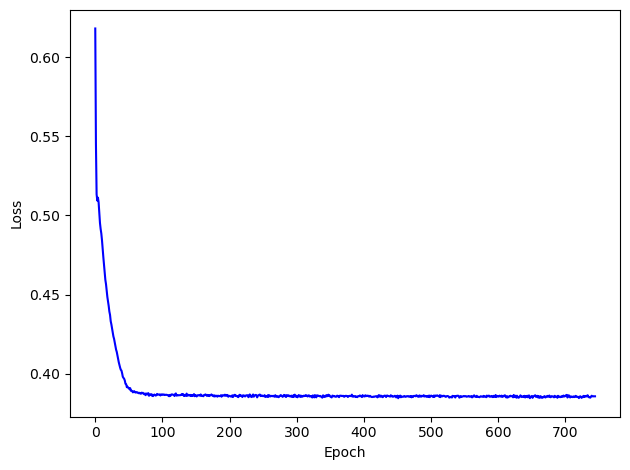

In [13]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()

In [14]:
# save IRT parameters to matrix
if OUTNAME == 'IRT' and IRT_DIMS == 1:    
    #z_dict = model.get_embeddings(train_data.to(device))
    z_dict = output_dict['embedding_0']
    df_item['IRT1_difficulty'] = -z_dict['offset']
    df_item['IRT1_discrimination'] = z_dict['discrimination']
    df_item['IRT1_discrimination_transf'] = z_dict['item']
    ability = z_dict['ability']
    df_edge['IRT1_ability'] = ability.ravel()
    
    aux_data = (df, df_student, df_item, df_edge, 
    train_losses, 
    train_edge_indices, val_edge_indices, test_edge_indices,
    data.cpu(), train_data.cpu(), val_data.cpu().cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

    with open(f'./results/{OUTNAME}_{DATASET}_aux_data_IRT1.pkl', 'wb') as handle:
        pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    df_item_clean = df_item.dropna(subset=['IRT_difficulty', 'IRT1_difficulty'])    
    
    fig = plt.figure()
    sns.scatterplot(x='IRT_difficulty', y='IRT1_difficulty', data=df_item, hue='scale')
    plt.title('Difficulty')
    print('Difficulty:', pearsonr(df_item_clean['IRT1_difficulty'], df_item_clean['IRT_difficulty']))
    
    edge_feat = train_data['student', 'responds', 'item'].edge_attr.detach().cpu().numpy()
    df_edge_clean = df_edge.dropna(subset=['IRT1_ability', 'ability', 'age'])
    fig = plt.figure()
    sns.scatterplot(x='age', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Age-Ability')
    
    fig = plt.figure()
    sns.scatterplot(x='grade', y='IRT1_ability', data=df_edge_clean, hue='age')
    plt.title('Grade-Ability')
    print('Age-Ability:', pearsonr(df_edge_clean['age'], df_edge_clean['IRT1_ability']))

    fig = plt.figure()
    sns.scatterplot(x='ability', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Ability')
    print('Ability:', pearsonr(df_edge_clean['ability'], df_edge_clean['IRT1_ability']))
    